In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
# avoid font type 3, use TrueType font http://phyletica.org/matplotlib-fonts/
plt.rcParams['mathtext.fontset']= 'cm'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

## Load config file:
Because the config file located in a different foder, first we add the parent path into this working space.

In [2]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, "..")
cfg = importlib.import_module('config.turtlebot3_config').config
print(cfg)

{'sceanrio': 'triangular_world', 'look_back': 120, 'look_ahead': 1, 'step_window': 1, 'feature_in': ['pose_pose_position_x', 'pose_pose_position_y'], 'feature_out': ['pose_pose_position_x', 'pose_pose_position_y'], 'lstm_inversed': False, 'synthesized_test': True, 'synthesized_prob': 0.005, 'synthesized_type': 'spike', 'synthesized_burst_width': 10, 'encoder_layers': [300], 'decoder_layers': [300], 'bidirection': True, 'stateful': False, 'batch_size': 64, 'droprate': 0.1, 'loss': 'mean_squared_error', 'learning_rate': 0.0005, 'use_gpu': True, 'batch_size_inference': 1024}


# Part 1: Load data and plot data

The dataset is collected in the simulated environment (`turtlebot3_myworld.launch`) in Gazebo environment with three files: 
* cmd_vel.csv: consists of control command sent from move_base controller.
* imd.csv: contains raw IMU data.
* odometry.csv: contains odometry of mobile robot.


In [19]:
temp_odom = pd.read_csv('../dataset/turtlebot3/normal/odometry.csv')

In [22]:
temp_odom.head(60)

header_seq  h_stamp_secs  h_stamp_nsecs  pose_pose_position_x  \
0       391648         13357       59000000             -0.696622   
1       391649         13357       93000000             -0.703822   
2       391650         13357      126000000             -0.710855   
3       391651         13357      159000000             -0.717993   
4       391652         13357      193000000             -0.725434   
5       391653         13357      226000000             -0.732651   
6       391654         13357      259000000             -0.739864   
7       391655         13357      293000000             -0.747154   
8       391656         13357      326000000             -0.754098   
9       391657         13357      359000000             -0.760892   
10      391658         13357      393000000             -0.768053   
11      391659         13357      426000000             -0.775188   
12      391660         13357      459000000             -0.782363   
13      391661         13357      493000000             -0.789477   
14      391662         13357      526000000             -0.796217   
15      391663         13357      559000000             -0.802951   
16      391664         13357      593000000             -0.810082   
17      391665         13357      626000000             -0.817203   
18      391666         13357      659000000             -0.824336   
19      391667         13357      693000000             -0.831519   
20      391668         13357      726000000             -0.838516   
21      391669         13357      759000000             -0.845657   
22      391670         13357      793000000             -0.852738   
23      391671         13357      826000000             -0.859529   
24      391672         13357      859000000             -0.866243   
25      391673         13357      893000000             -0.873319   
26      391674         13357      924000000             -0.880390   
27      391675         13357      959000000             -0.887524   
28      391676         13357      993000000             -0.894510   
29      391677         13358       26000000             -0.901039   
30      391678         13358       59000000             -0.907675   
31      391679         13358       93000000             -0.914649   
32      391680         13358      126000000             -0.921689   
33      391681         13358      159000000             -0.928821   
34      391682         13358      193000000             -0.935750   
35      391683         13358      226000000             -0.941700   
36      391684         13358      259000000             -0.946939   
37      391685         13358      293000000             -0.952411   
38      391686         13358      326000000             -0.958136   
39      391687         13358      359000000             -0.963877   
40      391688         13358      393000000             -0.969805   
41      391689         13358      426000000             -0.975695   
42      391690         13358      459000000             -0.981744   
43      391691         13358      493000000             -0.987612   
44      391692         13358      526000000             -0.993209   
45      391693         13358      559000000             -0.998855   
46      391694         13358      593000000             -1.004356   
47      391695         13358      626000000             -1.009591   
48      391696         13358      659000000             -1.014811   
49      391697         13358      693000000             -1.020361   
50      391698         13358      726000000             -1.026159   
51      391699         13358      759000000             -1.032479   
52      391700         13358      793000000             -1.039351   
53      391701         13358      826000000             -1.046433   
54      391702         13358      859000000             -1.053628   
55      391703         13358      893000000             -1.060999   
56      391704         13358      926000000             -1.068175   
57

Look at the above table, we can guess the collected frequency of odometry is 30 Hz.

In [4]:
temp_odom.describe()

header_seq  h_stamp_secs  h_stamp_nsecs  pose_pose_position_x  \
count   32510.000000  32510.000000   3.251000e+04          32510.000000   
mean   407970.064288  13923.404952   5.092844e+08             -0.008665   
std      9385.724323    313.116981   2.884147e+08              1.413369   
min    391648.000000  13357.000000   2.000000e+07             -1.908424   
25%    399843.250000  13653.000000   2.590000e+08             -1.312246   
50%    407970.500000  13924.000000   4.930000e+08             -0.238629   
75%    416097.750000  14194.000000   7.590000e+08              1.577709   
max    424225.000000  14465.000000   9.930000e+08              2.025131   

       pose_pose_position_y  pose_pose_position_z  pose_pose_orientation_x  \
count          32510.000000          3.251000e+04             32510.000000   
mean               0.032967         -1.001570e-03                 0.000094   
std                1.383304          3.148910e-07                 0.002524   
min               -1.908847         -1.002784e-03                -0.003862   
25%               -1.472461         -1.001760e-03                -0.002256   
50%                0.048009         -1.001571e-03                 0.000111   
75%                1.487573         -1.001433e-03                 0.002451   
max                1.978935         -1.000386e-03                 0.003861   

       pose_pose_orientation_y  pose_pose_orientation_z  \
count             32510.000000             32510.000000   
mean                  0.000094                -0.024308   
std                   0.002524                 0.654618   
min                  -0.003862                -0.999993   
25%                  -0.002256                -0.634396   
50%                   0.000111                -0.029972   
75%                   0.002451                 0.586452   
max                   0.003861                 0.999993   

       pose_pose_orientation_w  twist_twist_linear_x  twist_twist_linear_y  \
count             32510.000000          32510.000000          3.251000e+04   
mean                 -0.050599              0.159842          2.937676e-05   
std                   0.753883              0.102695          1.040065e-04   
min                  -0.999993             -0.231180         -2.790708e-03   
25%                  -0.815502              0.133702         -9.918592e-07   
50%                  -0.060218              0.212469          2.461682e-05   
75%                   0.752293              0.220494          5.818808e-05   
max                   0.999993              0.236291          6.356790e-03   

       twist_twist_linear_z  twist_twist_angular_x  twist_twist_angular_y  \
count               32510.0                32510.0                32510.0   
mean                    0.0                    0.0                    0.0   
std                     0.0                    0.0                    0.0   
min                     0.0                    0.0                    0.0   
25%                     0.0                    0.0                    0.0   
50%                     0.0                    0.0                    0.0   
75%                     0.0                    0.0                    0.0   
max                     0.0                    0.0                    0.0   

       twist_twist_angular_z  
count           32510.000000  
mean               -0.079784  
std                 0.232909  
min                -1.681922  
25%                -0.152258  
50%                -0.064893  
75%                 0.000873  
max                 1.266098

## Plot input and output feature data

<AxesSubplot:title={'center':'Feature input (Position)'}>

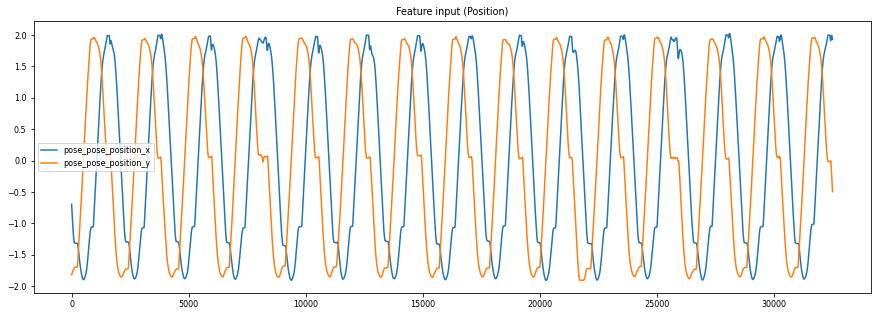

In [20]:
temp_odom.plot.line(y=cfg['feature_in'][0:4], title='Feature input (Position)', figsize=(15,5))

In [23]:
temp_odom.plot.line(y=cfg['feature_in'][4:6], title='Feature input (Twist cmd_vel)', figsize=(15,5))

TypeError: no numeric data to plot

In [ ]:
temp_odom.plot.line(y=['twist_twist_linear_x','twist_twist_linear_y'], title='Feature input (Twist cmd_vel)', figsize=(15,5))

In [ ]:
temp_odom.plot.line(y=cfg['feature_out'],
                    title='Feature out (Position output)', figsize=(15,5))

## Standardizing data 

In [24]:
from sklearn.preprocessing import StandardScaler
def standardize(data):
    scaler = StandardScaler()
    print("shape data={}".format(data.shape))
    print("data mean {}, data variance {}".format(np.mean(data, axis=0),np.var(data, axis=0)))
    data = scaler.fit_transform(data)
    print("shape transformed data={}".format(data.shape))
    print("Scaler Mean: {}".format(scaler.mean_))
    print("Scaler Variance: {}".format(scaler.var_))
    print("data mean {}, data variance {}".format(np.mean(data, axis=0),np.var(data, axis=0)))
    return data, scaler

In [76]:
in_dataset = temp_odom[cfg['feature_in']]
out_dataset = temp_odom[cfg['feature_out']]
print("in_dataset={}, out_dataset={}".format(in_dataset.shape, out_dataset.shape))
len_data =len(in_dataset)
origin_input_train_set = in_dataset[:int(0.7*len_data)]
origin_input_test_set = in_dataset[int(0.7*len_data):]
origin_output_train_set = out_dataset[:int(0.7*len_data)]
origin_output_test_set = out_dataset[int(0.7*len_data):]
print("origin_input_train_set={}".format(origin_input_train_set.shape))
print("origin_output_train_set={}".format(origin_output_train_set.shape))

in_dataset=(32510, 2), out_dataset=(32510, 2)
origin_input_train_set=(22757, 2)
origin_output_train_set=(22757, 2)


In [77]:
train_input_data, input_scaler = standardize(origin_input_train_set)
test_input_data = input_scaler.transform(origin_input_test_set)
train_output_data, output_scaler = standardize(origin_output_train_set)
test_output_data = output_scaler.transform(origin_output_test_set)
print("train_input_data={}".format(train_input_data.shape))
print("train_output_data={}".format(train_output_data.shape))

shape data=(22757, 2)
data mean pose_pose_position_x   -0.054903
pose_pose_position_y   -0.000911
dtype: float64, data variance pose_pose_position_x    1.990196
pose_pose_position_y    1.919198
dtype: float64
shape transformed data=(22757, 2)
Scaler Mean: [-0.05490261 -0.00091102]
Scaler Variance: [1.99019616 1.91919828]
data mean [ 2.49784325e-18 -1.24892163e-17], data variance [1. 1.]
shape data=(22757, 2)
data mean pose_pose_position_x   -0.054903
pose_pose_position_y   -0.000911
dtype: float64, data variance pose_pose_position_x    1.990196
pose_pose_position_y    1.919198
dtype: float64
shape transformed data=(22757, 2)
Scaler Mean: [-0.05490261 -0.00091102]
Scaler Variance: [1.99019616 1.91919828]
data mean [ 2.49784325e-18 -1.24892163e-17], data variance [1. 1.]
train_input_data=(22757, 2)
train_output_data=(22757, 2)


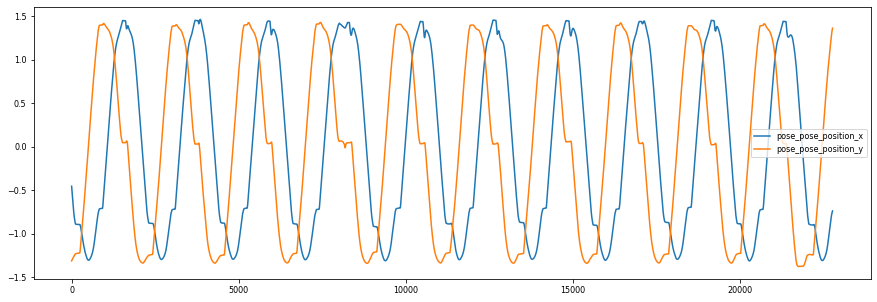

In [27]:
x = [i for i in range(len(train_input_data))]
plt.figure(figsize=(15,5))
for i,f in enumerate(cfg['feature_in']):
    plt.plot(x, train_input_data[:,i], label=f)
plt.legend()
plt.savefig("scaled_simu_turtlebot3_dataset.png",
                format='png', dpi=1000, bbox_inches="tight")
plt.show()

We split the messy figure into two figures, one with position while the other with twist cmd_vel.

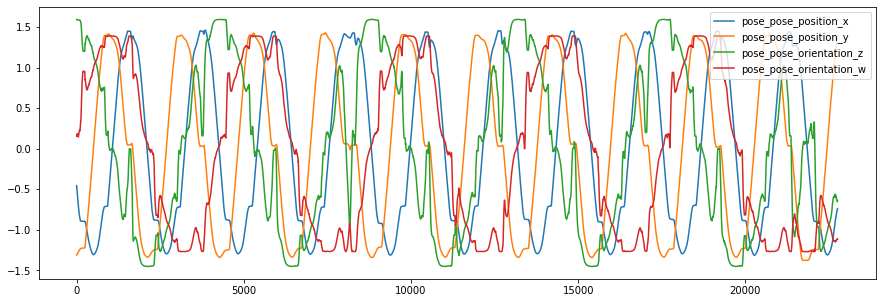

In [11]:
plt.figure(figsize=(15,5))
for i,f in enumerate(cfg['feature_in']):
    if 'pose_pose' in f:
        plt.plot(x, train_input_data[:,i], label=f)
plt.legend()
plt.savefig("scaled_simu_turtlebot3_position.png",
                format='png', dpi=1000, bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
for i,f in enumerate(cfg['feature_in']):
    if 'twist_twist' in f:
        plt.plot(x, train_input_data[:,i], label=f)
plt.legend()
plt.savefig("scaled_simu_turtlebot3_cmd_vel.png",
                format='png', dpi=1000, bbox_inches="tight")
plt.show()

In [ ]:
plot_len = 400
xx = [i for i in range(len(train_input_data[:plot_len]))]
plt.figure(figsize=(15,5))
for i,f in enumerate(cfg['feature_in']):
    if 'pose_pose' in f:
        plt.plot(xx, train_input_data[:plot_len,i], label=f)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
for i,f in enumerate(cfg['feature_in']):
    if 'twist_twist' in f:
        plt.plot(xx, train_input_data[:plot_len,i], label=f)
plt.legend()
plt.show()

## Part 1.3 Plot and verify the script of preprocessing data 
In this part, we import the functions of the pre-processing script and plot some seq input and sequence target

In [12]:
data = importlib.import_module('dataset.turtlebot3')

In [38]:
train_input, train_target = data.prepare_seq2seq_data(train_input_data,
        train_output_data, cfg['look_back'], cfg['look_ahead'], 
        cfg['step_window'])

In [39]:
print("train_input.shape={}, train_target.shape={}".format(
    train_input.shape, train_target.shape))
print("train_input[50,:30,1]={},\ntrain_target[50,:30,1]={}".format(
    train_input[50,:30,1], train_target[50,:30,1]))

train_input.shape=(1509, 120, 6), train_target.shape=(1509, 120, 4)
train_input[50,:30,1]=[1.18067996 1.18455984 1.18833606 1.19207712 1.19580308 1.19936133
 1.20280119 1.20625114 1.20956809 1.21303792 1.21689423 1.22085293
 1.22480368 1.22883718 1.23274485 1.23645957 1.24020597 1.24383382
 1.24754781 1.25145863 1.25529296 1.25917221 1.26314735 1.26693731
 1.27073875 1.27447077 1.27801201 1.28156059 1.2850049  1.28828947],
train_target[50,:30,1]=[1.23645957 1.24020597 1.24383382 1.24754781 1.25145863 1.25529296
 1.25917221 1.26314735 1.26693731 1.27073875 1.27447077 1.27801201
 1.28156059 1.2850049  1.28828947 1.29149958 1.29480582 1.29801927
 1.30127306 1.30447542 1.30743337 1.31019945 1.31292729 1.3155789
 1.31813907 1.320718   1.32320851 1.32566536 1.328197   1.33065674]


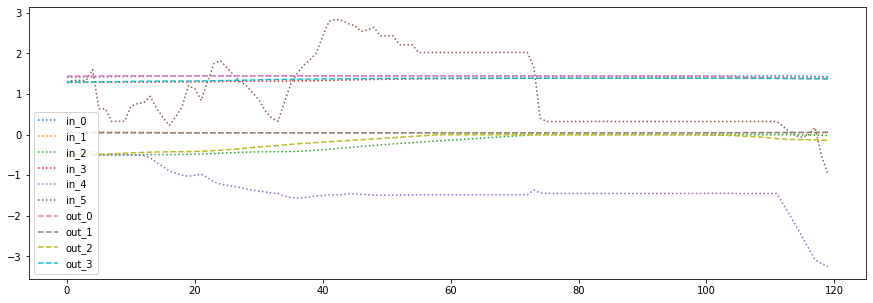

In [40]:
plt.figure(figsize=(15,5))
id = 100
plot_seqs = [train_input[id], train_target[id]]

xx = [i for i in range(cfg['look_back'])]

for i in range(len(cfg['feature_in'])):
    plt.plot(xx, train_input[id,:,i], label='in_{}'.format(i),linestyle=':')
    
for i in range(len(cfg['feature_out'])):
    plt.plot(xx, train_target[id,:,i], label='out_{}'.format(i),linestyle='--')
    
plt.legend()
plt.show()

## Part 1.2 Generate Synthesized Testset
We generate a synthesized testset which consists of some times of anomalies 
such as burst events, or peark signals adding to the normal data.

Adopt a method from Luo Tie paper: "Distributed Anomaly Detection using
Autoencoder Neural Networks in WSN for IoT". 

* **Spike**: a sharp rise followed immediately by a sharp decline in the sensor reading. Formally,
$$x'(t) = x(t) + vδ(t); $$
where $δ(t)$ is the Dirac delta function and $v$ is the magnitude of the spike.

* **Burst**: a continuous and constant offset persisting for a finite period of time. Formally,
$$x'(t) = \begin{cases}
     x(t) + v , t_\text{start} ≤ t ≤ t_\text{end}\\
        x(t), \text{otherwise}. 
     \end{cases}
$$

In both cases, $v$ can be negative.

For us, we get $v$ in between the range of sensor values for each dimension. 
We inject anomaly time $t$ at a random manner with probability p=15% of the normal dataset.

In [52]:
def generate_anomalous_spike_indices(length, prob):
    anomalous_labels = np.zeros(length)
    anomalous_indices = []
    i=0
    while i < length:                   
        if random.random() < prob:                 
            anomalous_labels[i] = 1.
            anomalous_indices.append(i)
        i+=1
    return np.array(anomalous_indices), anomalous_labels

In [94]:
def generate_anomalous_burst_indices(length, prob, burst_width):
    anomalous_labels = np.zeros(length)
    anomalous_indices = []
    i=0
    while i < length:                   
        if random.random() < prob:  
            for j in range(i, i+burst_width):
                if j >= length:
                    break
                else:                                                                  
                    anomalous_indices.append(j)
                    anomalous_labels[j] = 1.
            i += burst_width
        else:
            i += 1             
            
    return np.array(anomalous_indices), anomalous_labels

### Part 1.2.b: Generate and save the synthesized anomalous dataset as a test set
We name this test set with anomalous burst as: `test_input_anomaly_burst.npy` with probability of anomalous is 2% and each burst length is 50 samples which is half of our `look_back`. The groundtruth label is saved as `test_anomaly_burst_label.npy`

In [45]:
print(origin_input_test_set, len(cfg['feature_in']))

       pose_pose_position_x  pose_pose_position_y
22757             -1.095151              1.890439
22758             -1.093168              1.893364
22759             -1.091122              1.896361
22760             -1.089198              1.899156
22761             -1.087247              1.901958
...                     ...                   ...
32505              1.938364             -0.469622
32506              1.935965             -0.476257
32507              1.933519             -0.482971
32508              1.931022             -0.489797
32509              1.928508             -0.496615

[9753 rows x 2 columns] 2


In [63]:
#contaminate_rate
prob = 0.005
anomalous_indices, anomalous_labels = generate_anomalous_spike_indices(len(origin_input_test_set), prob)
print("anomalous_indices={}, anomalous_labels={}".format(anomalous_indices, anomalous_labels.shape))

anomalous_indices=[ 260  316  818  833 1025 1126 1220 1340 1388 1612 1860 1883 1933 2289
 2340 2358 3180 3230 3298 3451 3727 3760 4109 4187 4358 4753 5000 5177
 5243 5301 5385 5562 6292 6447 6477 6733 6829 7466 7728 7831 8018 8061
 9080 9150 9231 9347 9361 9435], anomalous_labels=(9753,)


In [78]:
synth_input_test = origin_input_test_set.copy()
synth_input_test.head()

pose_pose_position_x  pose_pose_position_y
22757             -1.095151              1.890439
22758             -1.093168              1.893364
22759             -1.091122              1.896361
22760             -1.089198              1.899156
22761             -1.087247              1.901958

In [79]:
synth_input_test.iloc[anomalous_indices]

pose_pose_position_x  pose_pose_position_y
23017              0.024199              1.875653
23073              0.423410              1.821558
23575              1.929775              0.062656
23590              1.969756              0.010310
23782              1.565578             -1.274119
23883              0.975166             -1.675547
23977              0.310626             -1.815674
24097             -0.559016             -1.828107
24145             -0.891493             -1.771488
24369             -1.361239             -1.492652
24617             -1.876999              0.185695
24640             -1.865389              0.351980
24690             -1.811523              0.706543
25046             -0.807464              1.965139
25097             -0.440171              1.925135
25115             -0.311860              1.910530
25937              1.659043             -0.024752
25987              1.764251             -0.323031
26055              1.728814             -0.812350
26208              1.086039             -1.653798
26484             -0.861879             -1.801705
26517             -1.072971             -1.783279
26866             -1.790166             -0.590848
26944             -1.900707             -0.035990
27115             -1.652854              1.157340
27510              0.010435              1.848694
27757              1.575879              1.156516
27934              1.949227              0.078004
28000              1.997697              0.026774
28058              1.954990              0.038393
28142              1.977922             -0.381454
28319              1.355923             -1.461659
29049             -1.847926             -0.388218
29204             -1.811184              0.733685
29234             -1.752047              0.940126
29490             -1.051678              1.938039
29586             -0.753055              1.966236
30223              1.943799              0.056862
30485              1.506435             -1.327599
30588              0.874684             -1.709986
30775             -0.468964             -1.848011
30818             -0.774799             -1.806045
31837             -0.131428              1.881661
31907              0.373550              1.821837
31988              0.942650              1.680525
32104              1.580433              1.169645
32118              1.627129              1.077555
32192              1.760238              0.555721

In [80]:
origin_input_test_set['pose_pose_position_x'].max()

2.02513106881

In [81]:
for col in cfg['feature_in']:
    max_x = origin_input_test_set[col].max()
    min_x = origin_input_test_set[col].min()
    spike_magnitude = random.uniform(min_x, max_x)
    for i in anomalous_indices:
        synth_input_test.iloc[i][col] += (-1)**i*spike_magnitude

<AxesSubplot:title={'center':'Origin input test set'}>

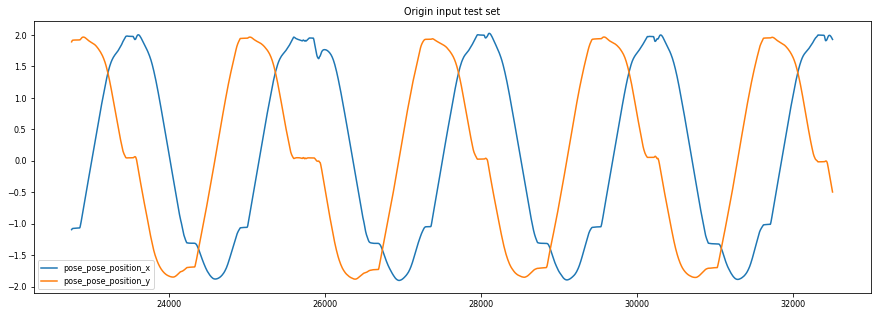

In [82]:
origin_input_test_set.plot.line(y=cfg['feature_in'], title='Origin input test set', figsize=(15,5))

<AxesSubplot:title={'center':'Synthesized input test set'}>

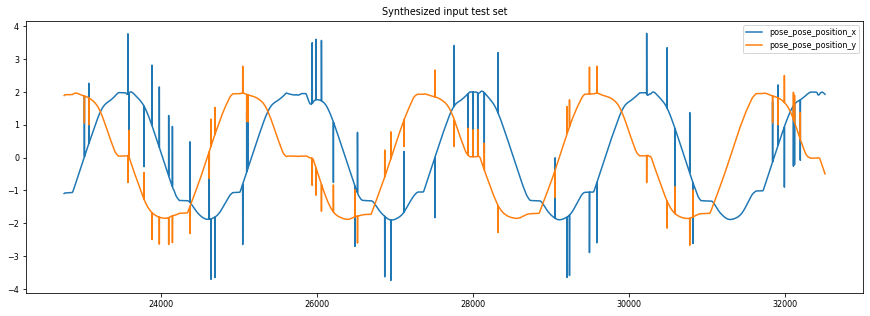

In [83]:
synth_input_test.plot.line(y=cfg['feature_in'], title='Synthesized input test set', figsize=(15,5))

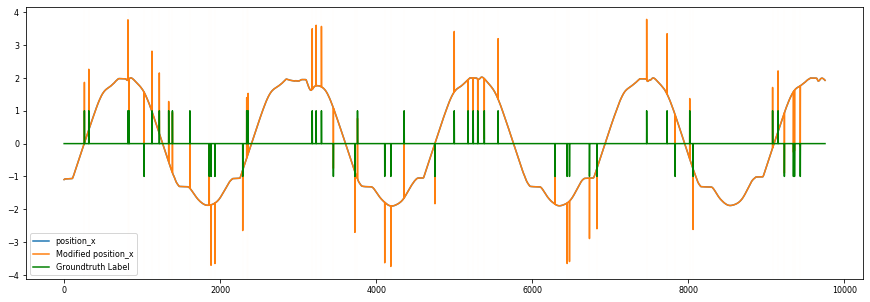

In [90]:
x = [i for i in range(len(origin_input_test_set))]
plt.figure(figsize=(15,5))
plt.plot(x, origin_input_test_set.values[:,0], label='position_x')
plt.plot(x, synth_input_test.values[:,0], label='Modified position_x')
for column in anomalous_indices:
    plt.axvline(x=column, color=sns.xkcd_rgb["peach"],alpha=.01)
plt.plot(x, anomalous_labels*np.sign(synth_input_test.values[:,0]), color='g', label='Groundtruth Label')
plt.legend()
plt.show()

#### Part 1.2.b.2 Burst anomaly generation

In [112]:
synth_burst_input_test = origin_input_test_set.copy()
synth_burst_input_test.head()

pose_pose_position_x  pose_pose_position_y
22757             -1.095151              1.890439
22758             -1.093168              1.893364
22759             -1.091122              1.896361
22760             -1.089198              1.899156
22761             -1.087247              1.901958

In [113]:
generate_anomalous_burst_indices
#contaminate_rate
prob = 0.005
burst_width = 20
anomalous_indices_burst, anomalous_labels_burst = generate_anomalous_burst_indices(len(origin_input_test_set),
                                                                                   prob, burst_width)
print("anomalous_indices={}, anomalous_labels={}".format(anomalous_indices_burst.shape, 
                                                         anomalous_labels_burst.shape))

anomalous_indices=(920,), anomalous_labels=(9753,)


In [114]:
for col in cfg['feature_in']:
    max_x = origin_input_test_set[col].max()
    min_x = origin_input_test_set[col].min()
    spike_magnitude = random.uniform(min_x, max_x)
    for i in anomalous_indices_burst:
        synth_burst_input_test.iloc[i][col] += (-1)**i*spike_magnitude

<AxesSubplot:title={'center':'Synthesized Burst input test set'}>

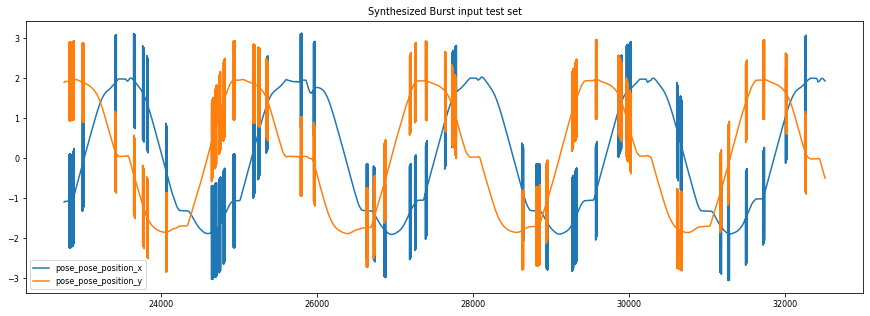

In [115]:
synth_burst_input_test.plot.line(y=cfg['feature_in'], title='Synthesized Burst input test set', figsize=(15,5))

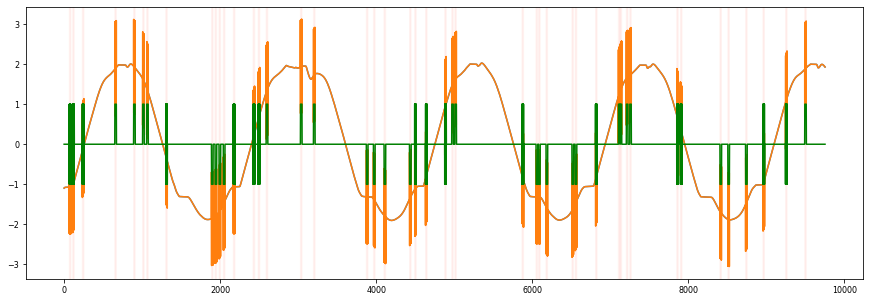

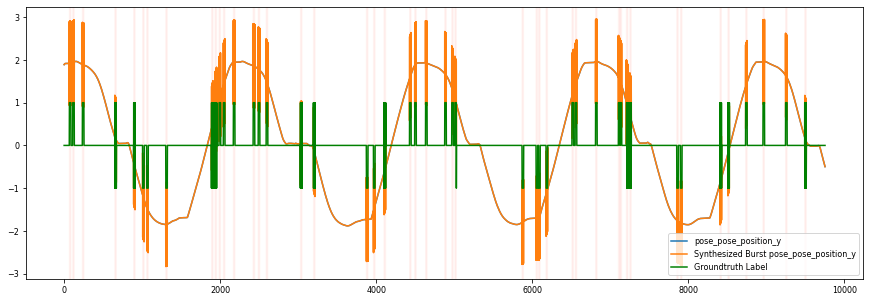

In [116]:
x = [i for i in range(len(origin_input_test_set))]
for i,feat in enumerate(cfg['feature_in']):
    plt.figure(figsize=(15,5))
    plt.plot(x, origin_input_test_set.values[:,i], label=feat)
    plt.plot(x, synth_burst_input_test.values[:,i], label='Synthesized Burst {}'.format(feat))
    for column in anomalous_indices_burst:
        plt.axvline(x=column, color=sns.xkcd_rgb["peach"],alpha=.01)
    plt.plot(x, anomalous_labels_burst*np.sign(synth_burst_input_test.values[:,i]),
             color='g', label='Groundtruth Label')


plt.legend()
plt.show()

# Part 2: Build model and run

# Part 3: Performance Evaluation

In [16]:
#dataset='turtlebot3_devbox_unidirection'

#dataset ='turtlebot3/lstm_seq2seq_devbox'
dataset ='turtlebot3/gru_seq2seq_devbox'
result_dir = '../results/{}'.format(dataset)
train_input = np.load('{}/train_input.npk'.format(result_dir),allow_pickle=True)
train_target = np.load('{}/train_target.npk'.format(result_dir),allow_pickle=True)
test_input = np.load('{}/test_input.npk'.format(result_dir),allow_pickle=True)
test_target = np.load('{}/test_target.npk'.format(result_dir),allow_pickle=True)
decoded_train = np.load('{}/decoded_train.npk'.format(result_dir),allow_pickle=True)
decoded_test =np.load('{}/decoded_test.npk'.format(result_dir),allow_pickle=True)

In [17]:
scaled_train_input = np.load('{}/scaled_train_input.npk'.format(result_dir),allow_pickle=True)
scaled_train_target = np.load('{}/scaled_train_target.npk'.format(result_dir),allow_pickle=True)
scaled_test_input = np.load('{}/scaled_test_input.npk'.format(result_dir),allow_pickle=True)
scaled_test_target = np.load('{}/scaled_test_target.npk'.format(result_dir),allow_pickle=True)
scaled_decoded_train = np.load('{}/scaled_decoded_train.npk'.format(result_dir),allow_pickle=True)
scaled_decoded_test =np.load('{}/scaled_decoded_test.npk'.format(result_dir),allow_pickle=True)

In [18]:
# scaled windows of datasets
sw_train_input = np.load('{}/swindow_train_input.npk'.format(result_dir),allow_pickle=True)
sw_train_target = np.load('{}/swindow_train_target.npk'.format(result_dir),allow_pickle=True)
sw_test_input = np.load('{}/swindow_test_input.npk'.format(result_dir),allow_pickle=True)
sw_test_target = np.load('{}/swindow_test_target.npk'.format(result_dir),allow_pickle=True)
sw_decoded_train = np.load('{}/swindow_decoded_train.npk'.format(result_dir),allow_pickle=True)
sw_decoded_test =np.load('{}/swindow_decoded_test.npk'.format(result_dir),allow_pickle=True)
print("sw_train_input={}, sw_train_target={},sw_decoded_train={}".format(
    sw_train_input.shape, sw_train_target.shape, sw_decoded_train.shape))
print("sw_test_input={}, sw_test_target={}, sw_decoded_test={}".format(
    sw_test_input.shape, sw_test_target.shape, sw_decoded_test.shape))

sw_train_input=(22637, 120, 2), sw_train_target=(22637, 120, 2),sw_decoded_train=(22637, 120, 2)
sw_test_input=(9633, 120, 2), sw_test_target=(9633, 120, 2), sw_decoded_test=(9633, 120, 2)


In [19]:
print(decoded_train.shape, decoded_test.shape)
print(scaled_decoded_train.shape, scaled_decoded_test.shape)

(22756, 2) (9752, 2)
(22756, 2) (9752, 2)


In [9]:
def plot_reconstruction(x, recon_x, label):    
    err = abs(x - recon_x)       
    fig = plt.figure(figsize=(10,5))
    plt.rcParams.update({'font.size': 8})    
    plt.plot(x, label='Ground truth')
    plt.plot(recon_x, label='Reconstructed {}'.format(label))
    plt.plot(err, label='Error')
    
    plt.legend()
    plt.xlabel('Time steps')
    plt.ylabel('{}'.format(label))
    #plt.title("Reconstructed data of autoencoder_{} model.".format(layer))
    plt.savefig("turtlebot3_{}.pdf".format(label),\
                format='pdf', dpi=1000, bbox_inches="tight")
    plt.show()

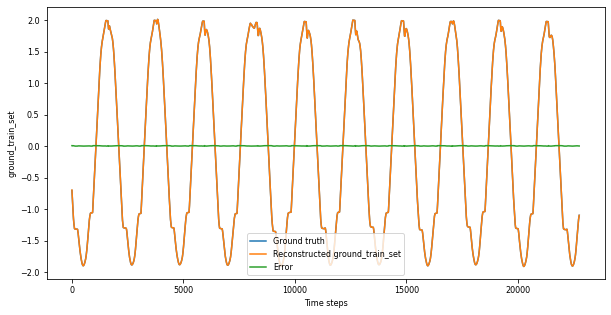

In [10]:
for i in range(1):
    plot_reconstruction(train_target[:,i], train_input[:,i], 'ground_train_set')

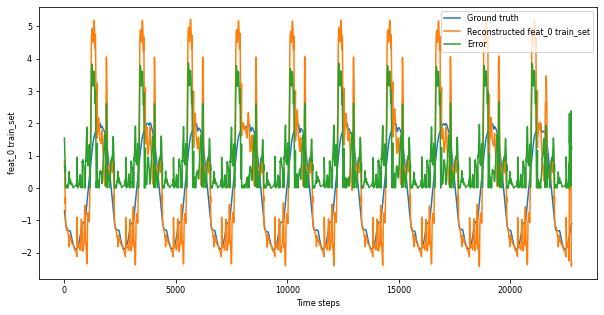

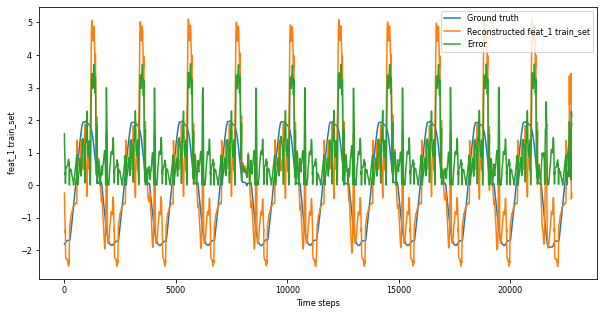

In [20]:
for i in range(2):
    plot_reconstruction(train_target[:,i], decoded_train[:,i], 'feat_{} train_set'.format(i))

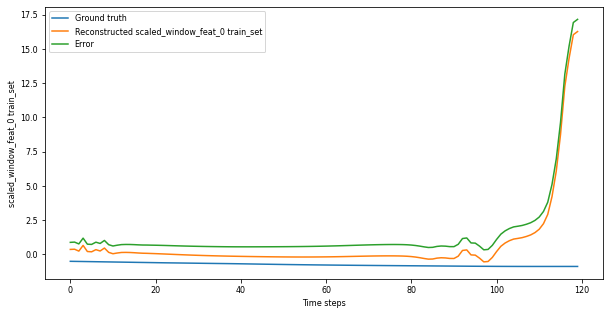

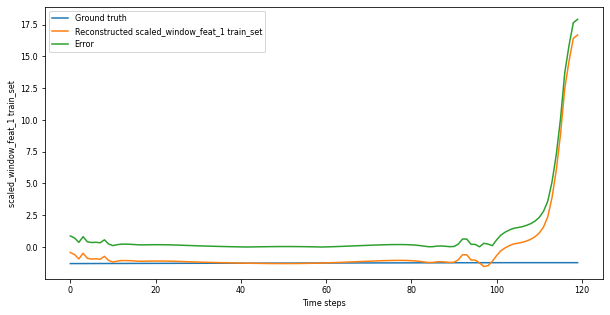

In [21]:
# plot a window of scaled window train set
wind= 11
for i in range(2):
    plot_reconstruction(sw_train_target[wind, :,i], sw_decoded_train[wind,:,i], 
                        'scaled_window_feat_{} train_set'.format(i))

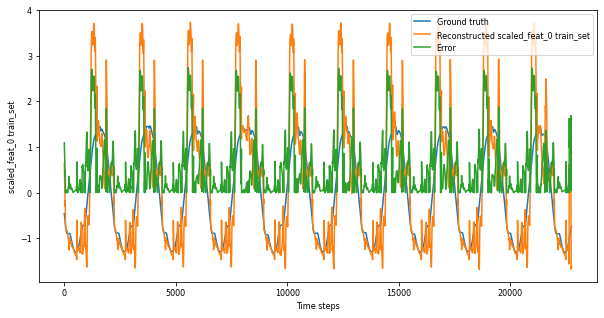

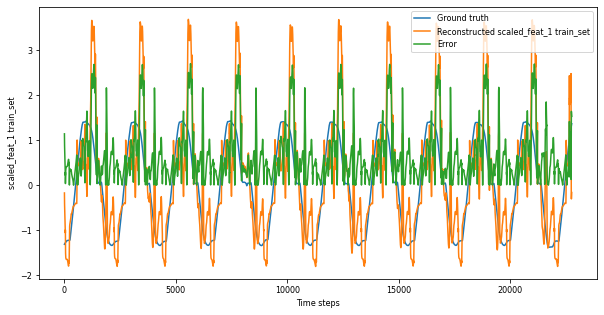

In [22]:
for i in range(2):
    plot_reconstruction(scaled_train_target[:,i], scaled_decoded_train[:,i],
                        'scaled_feat_{} train_set'.format(i))

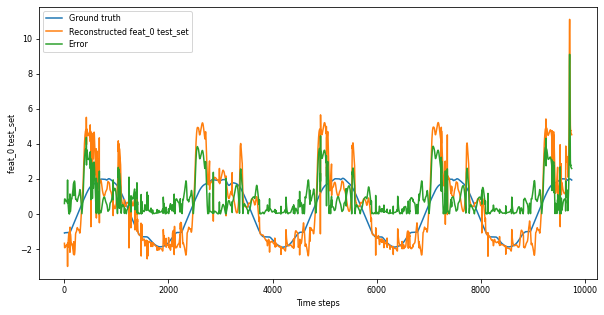

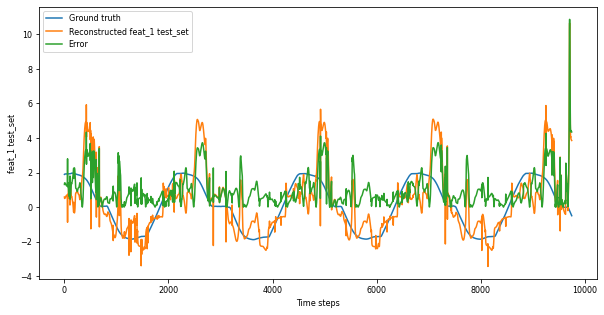

In [23]:
for i in range(2):
    plot_reconstruction(test_target[:,i], decoded_test[:,i], 'feat_{} test_set'.format(i))

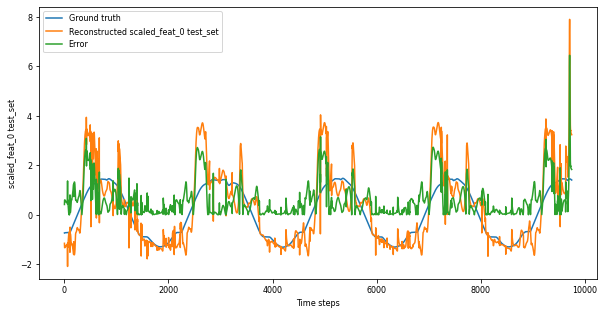

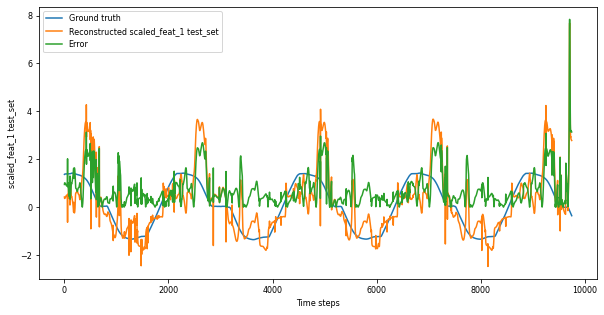

In [24]:
for i in range(2):
    plot_reconstruction(scaled_test_target[:,i], scaled_decoded_test[:,i], 
                        'scaled_feat_{} test_set'.format(i))